In [2]:
from transformers import BertTokenizer
'''
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])
'''

'\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-cased\')\n\nexample_text = \'I will watch Memento tonight\'\nbert_input = tokenizer(example_text,padding=\'max_length\', max_length = 10, \n                       truncation=True, return_tensors="pt")\n\n\nprint(bert_input[\'input_ids\'])\nprint(bert_input[\'token_type_ids\'])\nprint(bert_input[\'attention_mask\'])\n'

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [ ]:
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


In [3]:
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'traffic':0,
          'entertainment':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
import pandas as pd
df1 = pd.read_json('/Users/noarapoport/Documents/GitHub/final_50k_221118.json',lines=True)

In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df1.sample(frac=1, random_state=42), 
                                     [int(.8*len(df1)), int(.9*len(df1))])

In [7]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [8]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

KeyboardInterrupt: 

In [9]:
model_name = "bert-base-uncased"
max_length = 512

In [10]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [11]:
df_shuffled = df1.sample(frac=1, random_state=39)

# Reset the index
df_shuffled = df_shuffled.reset_index(drop=True)

df2 = df_shuffled[0:30000]
#print(df2)
#Select first 50000 rows

#past = time.time()
df3 = df2.groupby(df2["awesome_biz_id"],as_index=False).agg({"content":' '.join,"business_name":"first","is_entertainment":"first","is_traffic":"first"})
#now = time.time()
#print(now-past)
#print(df_new["business_name"])
print("df3",df3)

df3       awesome_biz_id                                            content  \
0         biz_000003  They do not make authentic Italian calzones. O...   
1         biz_000005  They are scammers!!! DO NOT BUY PRODUCTS FROM ...   
2         biz_000009  Just opened the paper bag to find a burnt croi...   
3         biz_000014  Needed a quick car wash!!! In the sign $4.19 i...   
4         biz_000020  This service is convenient, easy, and fast. Li...   
...              ...                                                ...   
18719     biz_049988  Vonsland! I swear, THIS IS ACTUALLY A SMALL TO...   
18720     biz_049993  This is a fun place to relax, create a paintin...   
18721     biz_049994  3 stars for food and service. I have a friend ...   
18722     biz_049995  It's wasn't bad as all. It's very slow and eve...   
18723     biz_049999  Great selection.. lots of high end options.. b...   

                    business_name  is_entertainment  is_traffic  
0                         Cal

In [1]:
df1['label'] = np.where(df['is_entertainment'] == True && df['is_traffic]', 1, 0)

SyntaxError: invalid syntax (1537949238.py, line 1)

In [ ]:
dataset = df1
target_names=dataset.target_names
news_text = dataset.data
labels = dataset.target
(train_texts,valid_texts,train_labels,valid_labels)=train_test_split(news_text, labels, test_size=0.3)

from transformers import BertTokenizerFast, BertForSequenceClassification

In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [15]:
df_shuffled = df1.sample(frac=1, random_state=39)

# Reset the index
df_shuffled = df_shuffled.reset_index(drop=True)

df2 = df_shuffled[0:30000]
#print(df2)
#Select first 50000 rows

#past = time.time()
df3 = df2.groupby(df2["awesome_biz_id"],as_index=False).agg({"content":' '.join,"business_name":"first","is_entertainment":"first","is_traffic":"first"})
#now = time.time()
#print(now-past)
#print(df_new["business_name"])
print("df3",df3)

df3       awesome_biz_id                                            content  \
0         biz_000003  They do not make authentic Italian calzones. O...   
1         biz_000005  They are scammers!!! DO NOT BUY PRODUCTS FROM ...   
2         biz_000009  Just opened the paper bag to find a burnt croi...   
3         biz_000014  Needed a quick car wash!!! In the sign $4.19 i...   
4         biz_000020  This service is convenient, easy, and fast. Li...   
...              ...                                                ...   
18719     biz_049988  Vonsland! I swear, THIS IS ACTUALLY A SMALL TO...   
18720     biz_049993  This is a fun place to relax, create a paintin...   
18721     biz_049994  3 stars for food and service. I have a friend ...   
18722     biz_049995  It's wasn't bad as all. It's very slow and eve...   
18723     biz_049999  Great selection.. lots of high end options.. b...   

                    business_name  is_entertainment  is_traffic  
0                         Cal

In [17]:
#Select first 50000 rows
# first10 = df1


df_shuffled = df1.sample(frac=1, random_state=42)
df_shuffled = df_shuffled.reset_index(drop=True)

#Extract business name and content from the first 50000 rows
df2 = df_shuffled[["business_name","content"]]

# Create a seperate data frame for label

label = ["is_entertainment","is_traffic"]
labeldf = df3[["is_entertainment","is_traffic"]]
print(labeldf)
df4 = df3[["business_name","content"]]
print(df4)
#Extract business name and content
#print(df2)

       is_entertainment  is_traffic
0                 False        True
1                  True        True
2                 False        True
3                 False        True
4                 False        True
...                 ...         ...
18719             False       False
18720             False       False
18721             False       False
18722              True       False
18723              True       False

[18724 rows x 2 columns]
                    business_name  \
0                         Calzone   
1               cheebapotshop.com   
2                 Perk Coffee Bar   
3                 MB KAZMO OIL CO   
4                  Wash-N-Deliver   
...                           ...   
18719         Lucky Liquor Market   
18720             Pinot's Palette   
18721                    Diem Hen   
18722        Empire Hookah Lounge   
18723  Minute Shops Liquor & Deli   

                                                 content  
0      They do not make authentic Ital

In [22]:
df4["text"] = df4['content'] +" "+ df4["business_name"]

/Users/noarapoport/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df4['text']

0        They do not make authentic Italian calzones. O...
1        They are scammers!!! DO NOT BUY PRODUCTS FROM ...
2        Just opened the paper bag to find a burnt croi...
3        Needed a quick car wash!!! In the sign $4.19 i...
4        This service is convenient, easy, and fast. Li...
                               ...                        
18719    Vonsland! I swear, THIS IS ACTUALLY A SMALL TO...
18720    This is a fun place to relax, create a paintin...
18721    3 stars for food and service. I have a friend ...
18722    It's wasn't bad as all. It's very slow and eve...
18723    Great selection.. lots of high end options.. b...
Name: text, Length: 18724, dtype: object

In [24]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df4['text'], labeldf[label[0]], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=labeldf[label[0]])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

<AxesSubplot:>

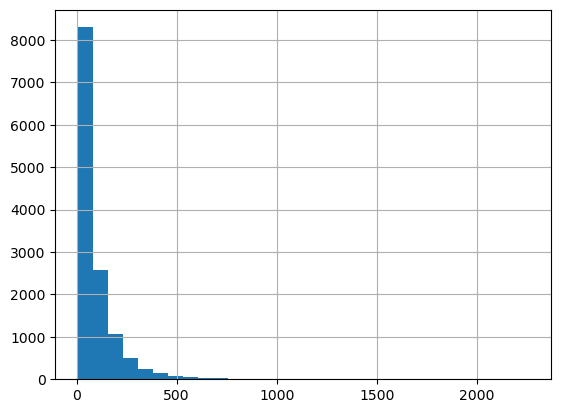

In [25]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [26]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 250,
    pad_to_max_length=True,
    truncation=True
)

/Users/noarapoport/opt/anaconda3/envs/tf/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2360: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [35]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [37]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [40]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
# model = model.to(device)

In [41]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5) 

2023-04-20 10:24:10.438958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/noarapoport/opt/anaconda3/envs/tf/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [43]:
from sklearn.utils.class_weight import compute_class_weight

compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.58027096 3.61445119]


In [45]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [46]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [47]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [48]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


AssertionError: Torch not compiled with CUDA enabled